In [1]:
push!(LOAD_PATH,"C:/JMB/PhysOcean.jl/src","."); using PhysOcean


In [2]:
push!(LOAD_PATH,"C:/JMB/divand.jl/src","."); using divand;cd("C:/JMB/divand.jl");cd("examples")
using divand
using PyPlot


Simple example with 

## METRICS usign METERS

In [3]:
dx = dy = 0.2

lonr = 27:dx:42
latr = 40:dy:47


depthr = [0., 10, 20, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000];

mask,(pm,pn,po),(xi,yi,zi) = divand_rectdom(lonr,latr,depthr)
#Now into meters
(pmm,pnm) = divand_metric(xi[:,:,1],yi[:,:,1])
pm=repeat(pmm,inner = (1,1,length(depthr)));
pn=repeat(pnm,inner = (1,1,length(depthr)));

mask[1:2,:,:]=false
mask[end-1:end,:,:]=false
#mask[:,1:2,:]=false
#mask[:,end-1:end,:]=false


false

Fake data

In [4]:
temp=16-zi/1600+cos.(1.4*xi+0*xi-zi/300)+xi/5.*xi./(zi+1)/2000.*(zi/1000+xi)
salt=28+xi

dens=density.(salt,temp,0)-1025;

In [5]:
Calculate geostrophic velocities assuming level 10 is no motion

LoadError: [91msyntax: extra token "geostrophic" after end of expression[39m

In [6]:
velocities,eta,Vflux=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);znomotion=10);
eta=eta-mean(eta);

Look at fluxes in y direction (south-north)

In [7]:
@show mean(var(Vflux[1].^2)),mean(var(Vflux[2].^2))

(mean(var(Vflux[1] .^ 2)), mean(var(Vflux[2] .^ 2))) = (4.863062073719452e34, 0.0)


(4.863062073719452e34, 0.0)

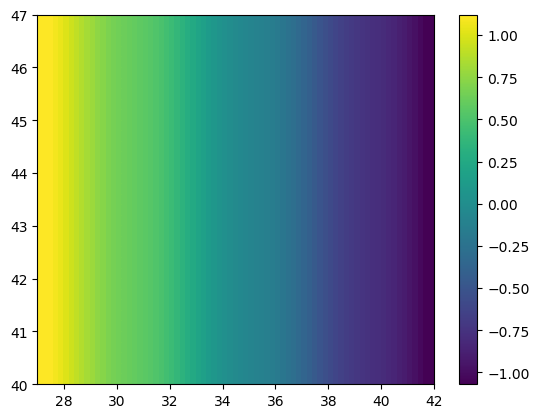

(PyObject <matplotlib.collections.PolyCollection object at 0x000000002BD525C0>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000002C2285C0>)

In [8]:
pcolor(xi[:,:,1],yi[:,:,1],eta),colorbar()

Now analyse eta with contstrain to have barotropic flow compensating the fluxes just calculated

In [9]:
# function to interpolate
fun(x,y) = sin.(6x) * cos.(6y)

# observations

x = [35];
y = [42];
f = [0.1]

h=deepestpoint(mask,zi)
len=500000.2
epsilon2=110000
rfluxes=0.0000001

#Need to scale fluxes by f/g
gsf=(earthgravity.(yi)./coriolisfrequency.(yi))[:,:,1]
fi,s=divandrun(mask[:,:,1],(pm[:,:,1],pn[:,:,1]),(xi[:,:,1],yi[:,:,1]),(x,y),f,len,epsilon2;moddim=[0,7],topographyforfluxes=(gsf.*h,0),fluxes=(Vflux[1],0),epsfluxes=rfluxes,alphabc=2,alpha=[1, 0, 1]);

In [10]:
Correction term

LoadError: [91msyntax: extra token "term" after end of expression[39m

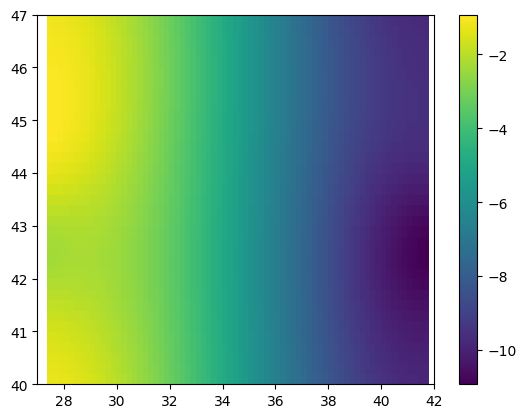

(PyObject <matplotlib.collections.PolyCollection object at 0x000000002C408F28>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000002C599518>)

In [11]:
pcolor(xi[:,:,1],yi[:,:,1],fi),colorbar()

For plotting and further calculation

In [12]:
fi[isnan.(fi)]=0

0

For verification look at how the correction term if applied with overall factor 0 to 2 changes fluxes

In [13]:
sf=collect(0.:0.11:2.5)
Ff=zeros(size(sf))
Ff2=zeros(size(sf))
Vfluxafter=0
for i=1:size(sf)[1]

    velafter,etaafter,Vfluxafter=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);ssh=eta+sf[i]*fi);
    Ff[i]=mean(Vfluxafter[1].^2)
    Ff2[i]=mean(Vfluxafter[2].^2)
end


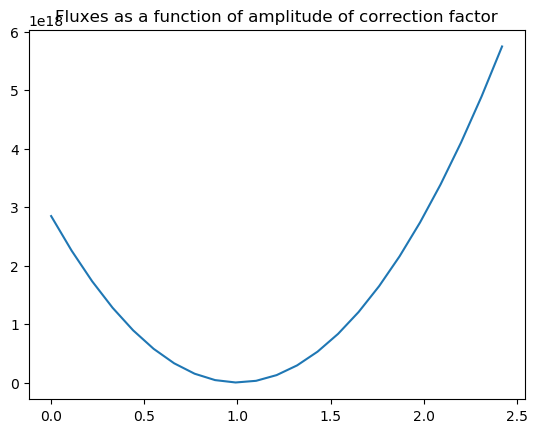

PyObject Text(0.5,1,u'Fluxes as a function of amplitude of correction factor')

In [14]:
plot(sf,Ff)
title("Fluxes as a function of amplitude of correction factor")

In [15]:
mean(Vflux[1].^2)

2.8453235588943135e18

So we can indeed use

In [16]:
velafter,etaafter,Vfluxafter=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);ssh=eta+fi);

In [17]:
mean(Vfluxafter[1].^2)

6.9537614215612e14

Verification: if we use zero density anomamy and barotropic correction term we get right flux correction

In [18]:
velafterb,etaafterb,Vfluxafterb=geostrophy(mask,0.0*dens,(pm,pn,po),(xi,yi,zi);ssh=fi);

In [19]:
(Vfluxafterb[1]+Vflux[1])./Vflux[1]

36-element Array{Float64,1}:
 -0.0246937  
 -0.0200163  
 -0.0162987  
 -0.0132516  
 -0.0101578  
 -0.00655682 
 -0.00205288 
  0.00251845 
  0.0078153  
  0.0149651  
  0.0223017  
  0.0277765  
  0.0302873  
  ⋮          
 -0.0163905  
 -0.0138488  
 -0.0111318  
 -0.00932786 
 -0.00621778 
 -0.00311978 
 -0.00129913 
 -0.000385658
  0.000905696
  0.00390109 
  0.00775244 
  0.0126175  